## Final Project Submission

Please fill out:
* Student name: Thien Nguyen 
* Student pace: **self paced** / part time / full time
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL: https://thiennguyen.blog/2019/09/21/classifying-different-types-of-pneumonia-with-deep-learning/


# Module 4 Final Project: Pnuemonia Detection via Deep Learning

### Background

Image classification and recognition is one of the most powerful applications of deep learning, and its usage is significantly important in the medical field where the slightest human error can put lives at risk. While advances in imaging technology have made it easier for medical professionls to detect certain ailments, these advances nonetheless rely on the expertise of the person at hand which is still prone to human error (e.g. due to stress or fatigue). Even doctors make mistakes.Therefore, using deep learning to mitigate human error can have a profound impact on the medical industry.

This project specifically focuses on 5,863 x-ray scans obtained from patients in Guangzhou, China. The dataset was pulled from kaggle uploaded by user Paul Mooney. The following details accompanied the dataset:

>"Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care."

While many kernels on this dataset focuses on a simple binary classification between *normal* and *pneumonia* patients, this investigation will build a deep learning model to classify between three categories--normal, bacterial, and viral pneumonia. Both a self-made and a pre-trained model will be used along with optimization strategies such as feature extraction and freezing. 

## Part 1. Gathering, Scrubbing, and Exploring Data

In [1]:
#Import necessary libraries which can be updated retroactively

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, models
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os, shutil
from glob import glob
import fileinput
from collections import defaultdict
import numpy as np
import os, shutil
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.applications import VGG19, inception_v3
from sklearn.metrics import confusion_matrix
import itertools
import random as rn
import pydot
import graphviz

Using TensorFlow backend.


## 1. Gathering and Rearranging Data

Although the kaggle dataset is already nicely divided into train, test, and validation directories, the pneumonia directory contains X-ray images of both bacterial and viral infections. This would be ok for binary classification, but since our model will try to classify between three groups, the directories should match as well.

In [28]:
directory_list = ['train', 'test','val']
types = ['bacteria', 'virus']


#creates a new directory for each type of pneumonia
for directory in directory_list:
    current_directory = directory + '/'
    current_dirList = os.listdir(current_directory)
    
    for infection in types:
        new_dir = os.path.join(current_directory +'/'+infection)
        os.mkdir(new_dir)
        
        for jpeg in current_dirList:
            if infection in jpeg:
                filename = jpeg
                origin = os.path.join(current_directory +'/' + filename)
                destination = os.path.join(new_dir +'/' +filename)
                shutil.copy(origin, destination)
            else:
                pass
    


Although it is nice that the folders are already divided into train, test, and validation sets, it's always good practice to examine data.

In [37]:
#check to see how many files are in each directory
train_dir = 'train/normal'
print('Total images in train/normal folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'train/bacteria'
print('Total images in train/bacteria folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'train/virus'
print('Total images in train/virus folder is {}'.format(len(os.listdir(train_dir))))

print('\n')

train_dir = 'val/normal'
print('Total images in train/normal folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'val/bacteria'
print('Total images in train/bacteria folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'val/virus'
print('Total images in val/virus folder is {}'.format(len(os.listdir(train_dir))))



Total images in train/normal folder is 1341
Total images in train/bacteria folder is 2530
Total images in train/virus folder is 1345


Total images in train/normal folder is 8
Total images in train/bacteria folder is 8
Total images in val/virus folder is 0


Given the number of images in the training data, the validation data seems a bit scarce. To increase the number of validation files a bit, especially for the virus folder, every 10th image from the train directory will be moved to the validation directory. 

In [43]:
folders = ['normal', 'bacteria','virus']
train = 'train/'
val = 'val/'

#Move about 10% of the files from the train folder to the validation folder
for folder in folders:    
    current_directory = train + folder
    dst_directory = val+folder
    
    current_dirList = os.listdir(current_directory)
    
    for img_count, img in enumerate(current_dirList):
        if img_count % 10 ==0:
            origin = os.path.join(current_directory + '/' + img)
            destination = os.path.join(dst_directory+'/'+img)
            shutil.move(origin, destination)

In [44]:
#Double check to make sure

train_dir = 'train/normal'
print('Total images in train/normal folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'train/bacteria'
print('Total images in train/bacteria folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'train/virus'
print('Total images in train/virus folder is {}'.format(len(os.listdir(train_dir))))

print('\n')

train_dir = 'val/normal'
print('Total images in train/normal folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'val/bacteria'
print('Total images in train/bacteria folder is {}'.format(len(os.listdir(train_dir))))

train_dir = 'val/virus'
print('Total images in val/virus folder is {}'.format(len(os.listdir(train_dir))))


Total images in train/normal folder is 1206
Total images in train/bacteria folder is 2277
Total images in train/virus folder is 1210


Total images in train/normal folder is 143
Total images in train/bacteria folder is 261
Total images in val/virus folder is 135


Given that there are over 1000 images in the train directory, a roughly 90/10 split should be fine for validation.

## 2. Modeling via Deep Learning
### a. Modeling with a Basic CNN 

In [6]:
#directory names
train_dir = 'train/'
test_dir = 'test/'
val_dir = 'val/'

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(rescale=1./255)

#set up generators
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

Found 4693 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


Even though there are substantially better pretrained models on imagenet, this first model will a very basic CNN with alternating layers of convolutional and pooling layers

In [2]:
#saves the best model weights based on the loss value; checkpoint path will be renamed for each different model if used
checkpoints_path = 'weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#stops the model if model does not improve after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)

callbacks = [checkpoint, early_stopping]

In [3]:
#create the model with Sequential
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(256, activation='relu'))

cnn_model.add(layers.Dense(3, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#compiles the model
cnn_model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['acc'])

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

There are about 8.5 million parameters, which seems like a good amount for our basic model. Next, we'll fit the model to the data and evaluate it with the test data. This model will only utilize 10 epoch with 10 steps per epoch to save time on run time. 

In [7]:
#fits the model
cnn_history = cnn_model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=20,
    callbacks = [early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
10/10 [==============================] - 15s 2s/step - loss: 1.5422 - acc: 0.3550 - val_loss: 1.1011 - val_acc: 0.4675
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 1.0593 - acc: 0.4950 - val_loss: 1.0592 - val_acc: 0.5063
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 1.0608 - acc: 0.4750 - val_loss: 1.0014 - val_acc: 0.4712
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.9654 - acc: 0.5450 - val_loss: 0.8531 - val_acc: 0.5800
Epoch 5/20
10/10 [==============================] - 14s 1s/step - loss: 0.7629 - acc: 0.7050 - val_loss: 0.7123 - val_acc: 0.6767
Epoch 6/20
10/10 [==============================] - 14s 1s/step - loss: 0.6435 - acc: 0.7700 - val_loss: 0.8752 - val_acc: 0.6090
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.8535 - acc: 0.6450 - val_loss: 0.7572 - val_acc: 0.7143
Epoch 8/20
10/10 [========================

In [19]:
#Creates two graphs of training/validation accuracy and loss over each epoch
def plot_acc_loss(history):
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epch = range(1, len(train_acc) + 1)
    plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
    plt.plot(epch, val_acc, 'g', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epch, train_loss, 'r.', label='Training loss')
    plt.plot(epch, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

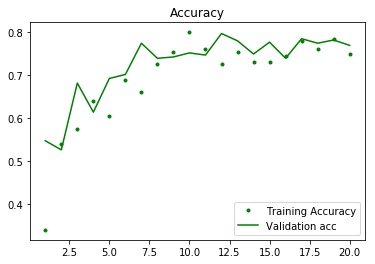

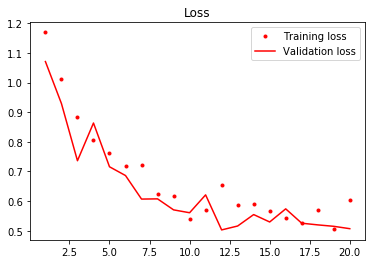

In [51]:
plot_acc_loss(cnn_history)

Both training and validation became more accurate over time and loss decreased as well. This means that the model did improve with each epoch without likely overfitting.

In [12]:
#prints the model accuracy compared to the test data
test_loss, test_acc = cnn_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


test acc: 0.7571138149748246


### Basic CNN Analysis
With less than 10 layers, the model accomplished a 75.7% accuracy rate in making the correct diagnosis simply based on x-ray images. This is more than double the accuracy of chance, but still falls below acceptable standards for the medical industry. It is likely this model **can** be improved upon with more layers and more epochs, but for the sake of time, we'll rely on pretained models henceforth.

## 2b. Modeling with Pretrained Networks

In [354]:
#load the pretrained model as the base
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [355]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [329]:
#create the model using the VGG19 pretrained as a base layer
pretrain_model = models.Sequential()
pretrain_model.add(cnn_base)
pretrain_model.add(layers.Flatten())
pretrain_model.add(layers.Dense(64, activation='relu'))
pretrain_model.add(layers.Dense(128, activation='relu'))
pretrain_model.add(layers.Dense(256, activation='relu'))
pretrain_model.add(layers.Dense(128, activation='relu'))
pretrain_model.add(layers.Dense(3, activation='softmax'))

pretrain_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                524352    
_________________________________________________________________
dense_76 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_77 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_78 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_79 (Dense)             (None, 3)                 387       
Total para

In [331]:
#Compilation
pretrain_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#Fitting the Model
pretrain_history = model.fit_generator(
              train_generator,
              steps_per_epoch= 20,
              epochs = 20,
              validation_data = validation_generator,
              validation_steps = 10)

Epoch 1/20
20/20 [==============================] - 17s 842ms/step - loss: 0.4344 - acc: 0.8175 - val_loss: 0.4813 - val_acc: 0.8100
Epoch 2/20
20/20 [==============================] - 14s 699ms/step - loss: 0.4101 - acc: 0.8150 - val_loss: 0.4900 - val_acc: 0.7800
Epoch 3/20
20/20 [==============================] - 14s 707ms/step - loss: 0.4090 - acc: 0.8150 - val_loss: 0.4563 - val_acc: 0.7889
Epoch 4/20
20/20 [==============================] - 14s 725ms/step - loss: 0.4559 - acc: 0.8075 - val_loss: 0.4352 - val_acc: 0.8250
Epoch 5/20
20/20 [==============================] - 15s 730ms/step - loss: 0.4658 - acc: 0.8025 - val_loss: 0.4564 - val_acc: 0.8141
Epoch 6/20
20/20 [==============================] - 15s 729ms/step - loss: 0.3971 - acc: 0.8475 - val_loss: 0.3410 - val_acc: 0.8350
Epoch 7/20
20/20 [==============================] - 14s 722ms/step - loss: 0.3901 - acc: 0.8350 - val_loss: 0.4539 - val_acc: 0.7700
Epoch 8/20
20/20 [==============================] - 14s 719ms/step - 

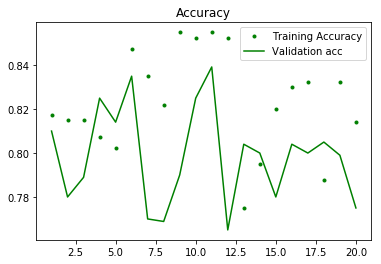

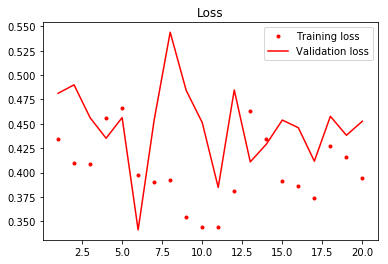

In [332]:
#plot graphs to check loss/accuracy of train/validation
plot_acc_loss(pretrain_history)

The above graph of the training and validation loss and accuracy is a bit concerning. The model seems to struggle and failed to improve with every epoches. 

In [333]:
#prints the model accuracy compared to the test data
test_loss, test_acc = pretrain_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.23863636302061317


### Pretrained Model Analysis

Strangely, the pretrained model did not do as well as expected and performed even poorer than chance level! The could be because the pretrained VGG19 base model is optmized for color images, which may translate to poorly to monochrome x-ray imaging. In addition, it is likely that freezing the pretrained model would allow higher accuracy. We shall continue using a pretrained model and incorporate additional techniques to see if the accuracy can be improved.

## 2c. Modeling with Pretrained Networks with Feature Extraction

For this portion, the pretrained model will be used for feature extraction.

In [298]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [36]:
#This function uses the pretrained network to extract the necessary features

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20
classes = 3

def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 4, 4, 512)) #creates 4-D numpy 0's array with sample amt in first layer
    labels = np.zeros(shape=(sample_amount, classes)) # creates 1-D numpy 0's array of labels with sample amount
    generator = datagen.flow_from_directory(
        directory, target_size=(150, 150), 
        batch_size = batch_size, 
        class_mode='categorical') #takes data from directory given
    i=0 #iteration
    for inputs_batch, labels_batch in generator:  #for every batch in the generator
        features_batch = cnn_base.predict(inputs_batch) #use base CNN model to extract features based on inputs for that batch
        features[i * batch_size : (i + 1) * batch_size] = features_batch #turns 0's in features to feature predicted by generator
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch #turns 0's in labels to labels predicted by generator
        i = i + 1  #increase interation
        if i * batch_size >= sample_amount: #if number of features >= sample amount, stops the program
            break
    return features, labels



In [300]:
#use the function above on each directory and reshape the array
train_features, train_labels = extract_features(train_dir, 2500) 
validation_features, validation_labels = extract_features(val_dir, 500) 
test_features, test_labels = extract_features(test_dir, 600)

train_features = np.reshape(train_features, (2500, 4 * 4 * 512)) #reshape to 2-D array
validation_features = np.reshape(validation_features, (500, 4 * 4 * 512))
test_features = np.reshape(test_features, (600, 4 * 4 * 512))

Found 4693 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [307]:

fe_model = models.Sequential() #builds sequential model
fe_model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
fe_model.add(layers.Dense(3, activation='softmax')) #converge to output layer

fe_model.compile(optimizer='adam', #compiles model
              loss='categorical_crossentropy',
              metrics=['acc'])

fe_history = fe_model.fit(train_features, train_labels, #fits model to train/valid feature/labels
                    epochs=20,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks = [early_stopping])

Train on 2500 samples, validate on 500 samples
Epoch 1/20
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7264 - acc: 0.7088 - val_loss: 0.5388 - val_acc: 0.7500
Epoch 2/20
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4673 - acc: 0.7884 - val_loss: 0.5974 - val_acc: 0.7420
Epoch 3/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.4369 - acc: 0.8060 - val_loss: 0.4532 - val_acc: 0.8280
Epoch 4/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3981 - acc: 0.8256 - val_loss: 0.5034 - val_acc: 0.7800
Epoch 5/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3952 - acc: 0.8292 - val_loss: 0.4886 - val_acc: 0.7820
Epoch 6/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3861 - acc: 0.8260 - val_loss: 0.4905 - val_acc: 0.7840
Epoch 7/20
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3595 - acc: 0.8360 - val_loss: 0.4662 - val_acc: 0.8160
Epoch 8/20
2500

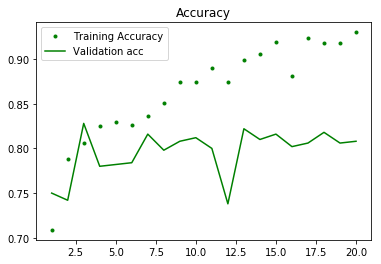

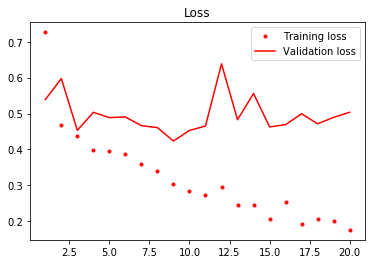

In [317]:
plot_acc_loss(fe_history)

Since validation accuracy does not increase with training accuracy, the model has most likely overfitted.

In [318]:
test_loss, test_acc = fe_model.evaluate(test_features, test_labels)#eval model using test feats/labels
print('test acc:', test_acc)


600/600 [==============================] - 0s 226us/step
test acc: 0.6699999992052714


### Pretrained Model with Feature Extraction Analysis

There is substantial improvement with feature extraction, but it falls embarassingly behind even our basic CNN. However, the graphs suggest that overfitting occurred since validation did not correlate with training loss. It would be wise to repeat the model with less epochs.

In [334]:
#Rerun the feature extraction model with few epochs to prevent overfitting
fe_history = fe_model.fit(train_features, train_labels, #fits model to train/valid feature/labels
                    epochs=3,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks = [early_stopping])

test_loss, test_acc = fe_model.evaluate(test_features, test_labels)#eval model using test feats/labels
print('test acc:', test_acc)

Train on 2500 samples, validate on 500 samples
Epoch 1/3
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1772 - acc: 0.9308 - val_loss: 0.5614 - val_acc: 0.7980
Epoch 2/3
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1479 - acc: 0.9424 - val_loss: 0.5407 - val_acc: 0.8080
Epoch 3/3
600/600 [==============================] - 0s 313us/step
test acc: 0.7133333325386048


As expected, the model did not overfit with fewer epochs and in fact did about 5% better than before. This puts it essentially on par with our original model. 

## 2d. Feature Extraction with Freezing with a Pretrained Model

In [14]:
cnn_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [15]:
#build the model
freeze_model = models.Sequential()
freeze_model.add(cnn_base)
freeze_model.add(layers.Flatten())
freeze_model.add(layers.Dense(132, activation='relu'))
freeze_model.add(layers.Dense(3, activation='softmax'))

#freeze the base so weights can't be changed
cnn_base.trainable = False

#compile
freeze_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [16]:
#name of the file for the best weights
checkpoints_path = 'freeze_weights_base.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [17]:
freeze_history = freeze_model.fit_generator(
              train_generator,
              steps_per_epoch =20,
              epochs = 20,
              validation_data = validation_generator,
              validation_steps = 10,
              callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
20/20 [==============================] - 76s 4s/step - loss: 1.4519 - acc: 0.5200 - val_loss: 0.7603 - val_acc: 0.4550

Epoch 00001: val_loss improved from inf to 0.76028, saving model to freeze_weights_base.best.hdf5
Epoch 2/20
20/20 [==============================] - 78s 4s/step - loss: 0.6531 - acc: 0.6575 - val_loss: 0.6581 - val_acc: 0.6650

Epoch 00002: val_loss improved from 0.76028 to 0.65814, saving model to freeze_weights_base.best.hdf5
Epoch 3/20
20/20 [==============================] - 77s 4s/step - loss: 0.6381 - acc: 0.6850 - val_loss: 0.6130 - val_acc: 0.7286

Epoch 00003: val_loss improved from 0.65814 to 0.61304, saving model to freeze_weights_base.best.hdf5
Epoch 4/20
20/20 [==============================] - 78s 4s/step - loss: 0.6396 - acc: 0.6975 - val_loss: 0.5906 - val_acc: 0.6950

Epoch 00004: val_loss improved from 0.61304 to 0.59059, saving model to freeze_weights_base.best.hdf5
Epoch 5/20
20/20 [======

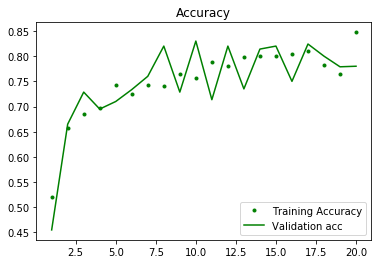

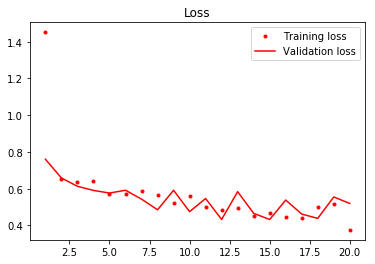

In [20]:
plot_acc_loss(freeze_history)

The graphs demonstrate no overfitting and suggests a possible accuracy of around 78%.

In [21]:
test_loss, test_acc = freeze_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.6504065041256145


Strangely, the test did not do as well as expected, as accuracy only reached 65%, which is below even the simple CNN model. Let's see if loading the best weights into the model can improve this.

In [22]:
freeze_model = models.Sequential()
freeze_model.add(cnn_base)
freeze_model.add(layers.Flatten())
freeze_model.add(layers.Dense(132, activation='relu'))
freeze_model.add(layers.Dense(3, activation='softmax'))


freeze_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#load the best weights into the model
freeze_model.load_weights('freeze_weights_base.best.hdf5')



In [23]:
test_loss, test_acc = freeze_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.7159090912785412


As expected, the accuracy increased a bit by using the best weights with an overall accuracy of 71.5%.

### Feature Extraction with Freezing Model Analysis

Freezing the pretained base layer did not help as much as expected. The overall accuracy is about the same as feature extraction without freezing, and even when the best weights were used, the model did not improve. However, this is still much better than simply using the pretained model directly without freezing or feature extraction. For now, some fine tuning may be able to help improve it slightly.

## 2e. Fine-Tuning a Frozen, Pretrained Model

First, let's reexamine our current model and check to see that the base is still frozen, which is a prerequisite for fine tuning.

In [10]:
freeze_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 132)               1081476   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 399       
Total params: 21,106,259
Trainable params: 1,081,875
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
#check if base is frozen
cnn_base.trainable

False

In [25]:
#function that takes a cnn base along with the name of a layer. Then, unfreezes every layer from the specified layer onwards

def make_trainable(cnn_base, layer_name):
    cnn_base.trainable = True
    set_trainable = False
    for layer in cnn_base.layers:  #sets every layer from the specified layer to the last layer as trainable. 
        if layer.name == layer_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

#makes the last 5 layers trainable
make_trainable(cnn_base, 'block5_conv1')

In [13]:
#check if the base has some unfrozen layers
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

There are now about 9.4 million trainable parameters, which comes from the unfrozen layers that we've selected for fine-tuning

In [26]:
freeze_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

ft_history = freeze_model.fit_generator(
              train_generator, 
              steps_per_epoch= 20,
              epochs = 20,
              validation_data = validation_generator,
              validation_steps = 10)

Epoch 1/20
20/20 [==============================] - 88s 4s/step - loss: 8.5224 - acc: 0.4675 - val_loss: 8.3425 - val_acc: 0.4824
Epoch 2/20
20/20 [==============================] - 89s 4s/step - loss: 8.1396 - acc: 0.4950 - val_loss: 7.4949 - val_acc: 0.5350
Epoch 3/20
20/20 [==============================] - 89s 4s/step - loss: 8.2509 - acc: 0.4881 - val_loss: 8.3814 - val_acc: 0.4800
Epoch 4/20
20/20 [==============================] - 91s 5s/step - loss: 8.2605 - acc: 0.4875 - val_loss: 8.5855 - val_acc: 0.4673
Epoch 5/20
20/20 [==============================] - 92s 5s/step - loss: 8.5829 - acc: 0.4675 - val_loss: 7.8979 - val_acc: 0.5100
Epoch 6/20
20/20 [==============================] - 91s 5s/step - loss: 8.6232 - acc: 0.4650 - val_loss: 8.8285 - val_acc: 0.4523
Epoch 7/20
20/20 [==============================] - 91s 5s/step - loss: 8.7038 - acc: 0.4600 - val_loss: 8.1396 - val_acc: 0.4950
Epoch 8/20
20/20 [==============================] - 91s 5s/step - loss: 7.9382 - acc: 0.50

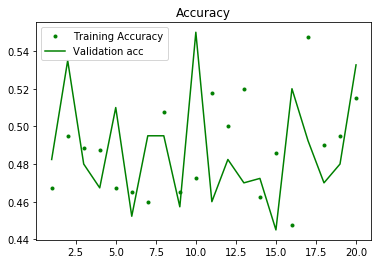

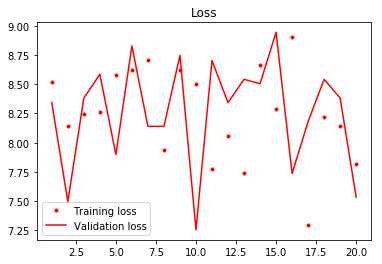

In [27]:
plot_acc_loss(ft_history)

In [28]:
#prints test accuracy
test_loss, test_acc = freeze_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.25619834784633855


### Fine-Tuned Model Analysis

Unfreezing some layers to fine tune the pretrained model did not fare well. It is likely that too many parameters were changed, which was overall detrimental to image recognition.

## 2f. Creating a Better Model from Scratch

The very first model only had 8 layers and about 8.5 million trainable parameters, but was still able to attain an impressive accuracy of over 70%. In addition, the model had less epochs than our pretrained models, and its accuracy/loss graph between training and validation data suggests that accuracy can be improved with more epochs. So for this final model, we shall try to make a deeper, denser CNN. To offset any extraordinarily long processing time, both model checkpoint and early stopping will be used.

In [29]:
better_model = models.Sequential()

better_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
better_model.add(layers.MaxPooling2D((2, 2)))

better_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
better_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
better_model.add(layers.MaxPooling2D((2, 2)))

better_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
better_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
better_model.add(layers.MaxPooling2D((2, 2)))


better_model.add(layers.Flatten())
better_model.add(layers.Dense(256, activation='relu'))
better_model.add(layers.Dense(512, activation='relu'))
better_model.add(layers.Dense(64, activation='relu'))
better_model.add(layers.Dense(128, activation='relu'))
better_model.add(layers.Dense(3, activation='softmax'))

better_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 68, 68, 64)        65600     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 128)       147584    
__________

In [30]:
checkpoints_path = 'better_cnn_weights.best.hdf5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [33]:
better_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

better_history = better_model.fit_generator(
              train_generator, 
              steps_per_epoch= 20,
              epochs = 20,
              validation_data = validation_generator,
              validation_steps = 10,
              callbacks = [checkpoint])

Epoch 1/20
20/20 [==============================] - 27s 1s/step - loss: 1.0876 - acc: 0.4525 - val_loss: 1.0815 - val_acc: 0.4573

Epoch 00001: val_loss improved from inf to 1.08145, saving model to better_cnn_weights.best.hdf5
Epoch 2/20
20/20 [==============================] - 25s 1s/step - loss: 1.0641 - acc: 0.4875 - val_loss: 1.0628 - val_acc: 0.5050

Epoch 00002: val_loss improved from 1.08145 to 1.06277, saving model to better_cnn_weights.best.hdf5
Epoch 3/20
20/20 [==============================] - 26s 1s/step - loss: 1.0630 - acc: 0.4850 - val_loss: 1.0486 - val_acc: 0.4900

Epoch 00003: val_loss improved from 1.06277 to 1.04865, saving model to better_cnn_weights.best.hdf5
Epoch 4/20
20/20 [==============================] - 26s 1s/step - loss: 1.0591 - acc: 0.4775 - val_loss: 1.0703 - val_acc: 0.4573

Epoch 00004: val_loss did not improve from 1.04865
Epoch 5/20
20/20 [==============================] - 26s 1s/step - loss: 1.0789 - acc: 0.4450 - val_loss: 1.0301 - val_acc: 0.5

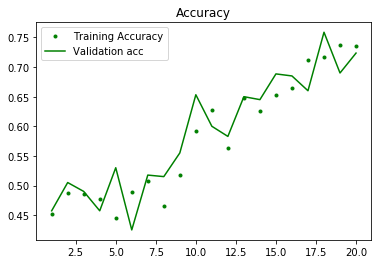

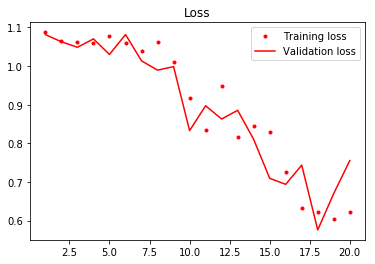

In [34]:
plot_acc_loss(better_history)

In [35]:
test_loss, test_acc = better_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.6064049585545359


As the graphs suggest, there definitely a drop in loss after about 18 epochs. Therefore, using the best weights should yield substantially better accuracy.

In [36]:
#build the model again
better_model = models.Sequential()

better_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150 ,150,  3)))
better_model.add(layers.MaxPooling2D((2, 2)))

better_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
better_model.add(layers.Conv2D(64, (4, 4), activation='relu'))
better_model.add(layers.MaxPooling2D((2, 2)))

better_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
better_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
better_model.add(layers.MaxPooling2D((2, 2)))


better_model.add(layers.Flatten())
better_model.add(layers.Dense(256, activation='relu'))
better_model.add(layers.Dense(512, activation='relu'))
better_model.add(layers.Dense(64, activation='relu'))
better_model.add(layers.Dense(128, activation='relu'))
better_model.add(layers.Dense(3, activation='softmax'))

#compile it again
better_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

#load weights
better_model.load_weights('weights_base.best.hdf5')

#evaluate the model
test_loss, test_acc = better_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.65650405680261


As expected, accuracy jumped up to 65.6%,. However, this is surprisingly not better than our original model.

## Project Conclusion



It is surprising that the best model attained was built from scratch instead of being based on a pretained model. There might be two reasons for this. First,the VGG19 base is more optimized for color images, which has more defined edges and rgb values. The fact that the pretrained model's accuracy went down substantially when a model was built without freezing the base also supports this fact. This also extends to the fact that fine-tuning dropped the model's accuracy down substantially as well. 


Second, 
The overall best accuracy rate of 75% is not bad at more than double chance level but remains far from applicable in a medical setting.

## Further Considerations
*Reflections and future project considerations*

### Reflections
    - Streamline model compilation, fit, and accuracy score with functions and use pipelines for more efficiency.
    - Test pipeline with a simple model first and compile, fit, and evaluate all other models overnight to save time.
    - Streamline randomness of keras models to have reproducible results.
    - Incorporate image augmentation to feed the model more data.

### Future Projects
    - Create a model capable of image classification for all 5 types of pneumonia
    - Try more basic models that are less computationally expensive for comparison
    - Buffer image data with additional data (e.g. from lab tests)
    - Construct additional image classification models for other tests such as fMRI and CAT. 
    - Use different pretrained models as the base such as Inception, MobileNet, Resnet, etc.
    - Explore unsupervised models for image classification

# Project Summary

## 1. Obtaining and Preprocessing Data

>**A**. Data obtained from kaggle and data in training, validation, and testing directories were reorganized to contain 3 subdirectors-- normal, bacteria, and virus.

>**B**. Allocate about 10% of training data to validation directory, since validation data was lacking.

## 2. Image Classification Modeling with CNNs
*Note: All models utilized an Adam optimizer, 20 epochs, softmax activation, and accuracy as the metric. All models relying on pretained data used VGG19 as the base model*

>__A.__ Basic CNN (9 layers): Alternation between Conv2D and pooling layers with 2 dense layers. Overall accuracy with test data is **75.7**%

>__B__. Pretrained Model (weights unfrozen) with 5 dense layers: Overall accuracy of **23.4%**. This is the worst attained accuracy and most likely the result of the model changing the weights of the pretrained model. 

>__C__. Pretrained Model with Feature Extraction: Overall accuracy of **67%.**

>__D__. Pretrained Model with Feature Extraction Using Freezing w/ Model Checkpoint: Accuracy of **65%** after 20 epochs. Accuracy improved to 71.5% when using the best weights.

>__E__. Pretrained Model w/ Freezing and Fine-Tuning (of last 5 layers): Accuracy of **25.6%**. This is most likely due to the model changing too many weights that were essential to the original model, which follows the pattern of model B.

>__F__. Original Model w/ 14 layers & Model Checkpoint: Accuracy of **65.6%** with best weights checkpoint. 

## 3. Conclusion

> The best model for image classification was actually the simplest model at **75.7% accuracy** with the pretrained model with feature extraction coming in second. However, this difference is not significant enough to rule out the randomness of keras modeling. Conversely, **not freezing** weights had a significant, detrimental impact on accuracy. This was still true with fine-tuning, which meant that letting the model adjust the weights of the pretrained base layer decreased the overall accuracy of the model. This could be because VGG19 is already optimized, so changing its weights compromised its accuracy. 